In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from basics import *

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Speech Translation - BLEU

BLEU scores with varying amount of training data used

In [3]:
x_labels = ['16 hrs\n(10%)', '40 hrs', '52 hrs', '80 hrs', '160 hrs\n(100%)']
x_scale = np.array([10, 25, 33, 50, 100])

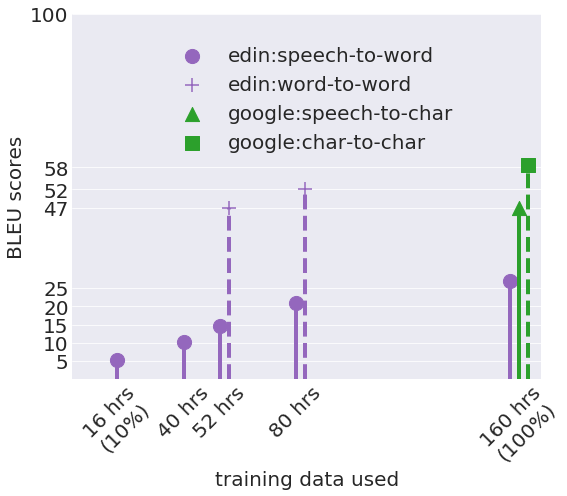

In [71]:
fig, ax = plt.subplots(figsize=(8,7),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

bar_y = np.array([5.26, 10.22, 14.5, 20.82, 27])
bar_x = np.array([10, 25, 33, 50, 98])

word2word_x = [35, 52]
word2word_y = [47, 52]

google_char2char_x = [102]
google_char2char_y = [58.7]

# x_labels = ["{0:d} hrs\n({1:d}%)".format(int(160 * (i/100)), i) for i in x_scale]
# x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]

bar_colors = [tableau20[0]]*6

ax.scatter(x=bar_x, y=bar_y, s=200, marker='o' , label="edin:speech-to-word", c=tableau20[8])

# word-to-word level
ax.scatter(x=word2word_x, y=word2word_y, s=200, marker='+' , label="edin:word-to-word", c=tableau20[8])

# google
ax.scatter(x=[100], y=[47], s=200, marker='^' , label="google:speech-to-char", c=tableau20[4])
ax.scatter(x=google_char2char_x, y=google_char2char_y, s=200, marker='s' , label="google:char-to-char", c=tableau20[4])

# -------------------------------------------------------------
# # old code
# ax = sns.regplot(x=bar_x, y=bar_y, ax=ax, 
#                  scatter_kws={"alpha":1.0, 's':200}, 
#                  line_kws={"linestyle":"--"},
#                  color=tableau20[8], fit_reg=False,
#                 label="our models")
# -------------------------------------------------------------

markerline, stemlines, baseline = ax.stem(bar_x, bar_y, linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem(word2word_x, word2word_y, linefmt='--', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem([100], [47], linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem(google_char2char_x, google_char2char_y, linefmt='--', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)


plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
plt.yticks(list(range(5,30,5))+[47, 52, 58, 100], rotation=0, fontsize=20)
ax.set_xlabel('training data used', size=20)
ax.set_ylabel('BLEU scores', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(20)

plt.legend(bbox_to_anchor=(.85, 0.96), framealpha=0, fontsize=20, ncol=1)
plt.ylim(0,100)
plt.xlim(0,105)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(fname="bleu_scores.pdf", dpi=300)

## Speech Translation - Precision and Recall

In [72]:
metrics = {'google': {}}

In [73]:
metrics['google'] = {}

google_p_vals = [np.array([58.26, 57.86, 57.98, 57.68]),
                 np.array([33.86, 33.62, 33.43, 33.12]),
                 np.array([20.85, 20.62, 20.48, 20.11]),
                 np.array([13.02, 12.75, 12.81, 12.43])]

metrics['google']['p'] = [np.mean(v) for v in google_p_vals]
metrics['google']['p_std'] = [np.std(v) / np.sqrt(len(v)) for v in google_p_vals]

google_r_vals = [np.array([57.36, 57.79, 57.68, 57.30]),
                 np.array([33.29, 33.56, 33.25, 32.89]),
                 np.array([20.48, 20.57, 20.36, 19.96]),
                 np.array([12.77, 12.71, 12.73, 12.34])]

metrics['google']['r'] = [np.mean(v) for v in google_r_vals]
metrics['google']['r_std'] = [np.std(v) / np.sqrt(len(v)) for v in google_r_vals]

In [74]:
model_files = {"s2w-0.10": "./sp2enw/sp_.10/",
               "s2w-0.25": "./sp2enw/sp_.25/",
               "s2w-0.33": "./sp2enw/sp_.33/",
               "s2w-0.50": "./sp2enw/sp_.50/",
               "s2w-1.0" : "./sp2enw/sp_1.0_l2e-3",               
               }

In [75]:
model_files.keys()

dict_keys(['s2w-0.10', 's2w-0.25', 's2w-0.33', 's2w-0.50', 's2w-1.0'])

In [76]:
for key, m_fil in model_files.items():
    with open(os.path.join(m_fil, "s2w_p_r.json"), "r") as out_f:
        metrics[key] = json.load(out_f)

In [77]:
for k in metrics:
    print(metrics[k]['p'][0])

57.945
20.422883770341393
28.236579899252156
36.13719482059899
40.54952846114025
41.38348979681784


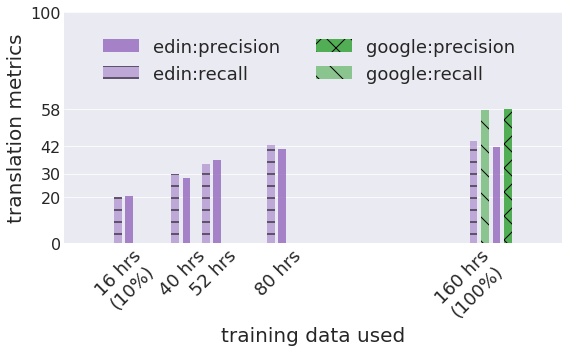

In [82]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

py_vals = [metrics[k]['p'][0] for k in metrics if k != "google"]
px_vals = x_scale-3
px_vals[-1] = 103
ax.bar(px_vals, py_vals, label="edin:precision", color=tableau20[8], hatch="", width=2, alpha=.8)

ry_vals = [metrics[k]['r'][0] for k in metrics if k != "google"]
rx_vals = x_scale-6
rx_vals[-1] = 97
ax.bar(rx_vals, ry_vals, label="edin:recall", color=tableau20[8], hatch="-", width=2, alpha=.5)


ax.bar([106], [metrics['google']['p'][0]], label="google:precision", color=tableau20[4], hatch='x', width=2, alpha=.8)
ax.bar([100], [metrics['google']['r'][0]], label="google:recall", color=tableau20[4], hatch='\\', width=2, alpha=.5)


plt.xticks(x_scale-4, x_labels, rotation=45)
plt.yticks([0,100]+list(range(20,40,10))+[42, 58], rotation=0, fontsize=18)

ax.set_xlabel('training data used', size=20)
ax.set_ylabel('translation metrics', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(18)

plt.yticks(fontsize=16, rotation=0)

plt.ylim(0,100)
plt.xlim(-10,120)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(0.94, 0.96), framealpha=0, fontsize=18, ncol=2)

fig.tight_layout()
fig.savefig(fname="s2t_prec_rec.png", dpi=300)

## Speech Translation - Sample Translations

In [2]:
sample_translations = {
    'reference' : """i ' m from puerto rico but i live here in denver colorado""",
    'google' : """i'm from puerto rico but i live here in denver colorado""",   
    "edin:160 hrs" : """i ' m from puerto rico but i live here in denver colorado""",
    'edin:80 hrs' : """i ' m from puerto rico but i live here in canada""",
    'edin:52 hrs' : """and i ' m from puerto rico but i live in the colorado""",
    'edin:40 hrs' : """and i ' m four five hours here in the same time here in canada""",
    'edin:16 hrs' : """and i was the united states i was in the united states""",
}

In [3]:
print("{0:20s} | {1:<60s}".format("model", "translation"))
print("-"*80)
print("\n".join(["{0:20s} | {1:60s}".format(k, v) for k, v in sample_translations.items()]))

model                | translation                                                 
--------------------------------------------------------------------------------
reference            | i ' m from puerto rico but i live here in denver colorado   
google               | i'm from puerto rico but i live here in denver colorado     
edin:160 hrs         | i ' m from puerto rico but i live here in denver colorado   
edin:80 hrs          | i ' m from puerto rico but i live here in canada            
edin:52 hrs          | and i ' m from puerto rico but i live in the colorado       
edin:40 hrs          | and i ' m four five hours here in the same time here in canada
edin:16 hrs          | and i was the united states i was in the united states      


## English word spotting

In [14]:
from IPython.display import Image

### Selected topics and their counts in the dev set

Number of topics = 28

total number of utterances in which topic words occur = 217
total utterances in dev set = 3977

To spot a keyword, we **stem** it, and then count the utterances in which the keyword occurs (using the translations).

**Note**: For this task, **we predict whether an utterance contains a keyword or not**. If there are multiple instances of the keyword in an utterance, only one will be counted


total tokens in dev set = 170,346

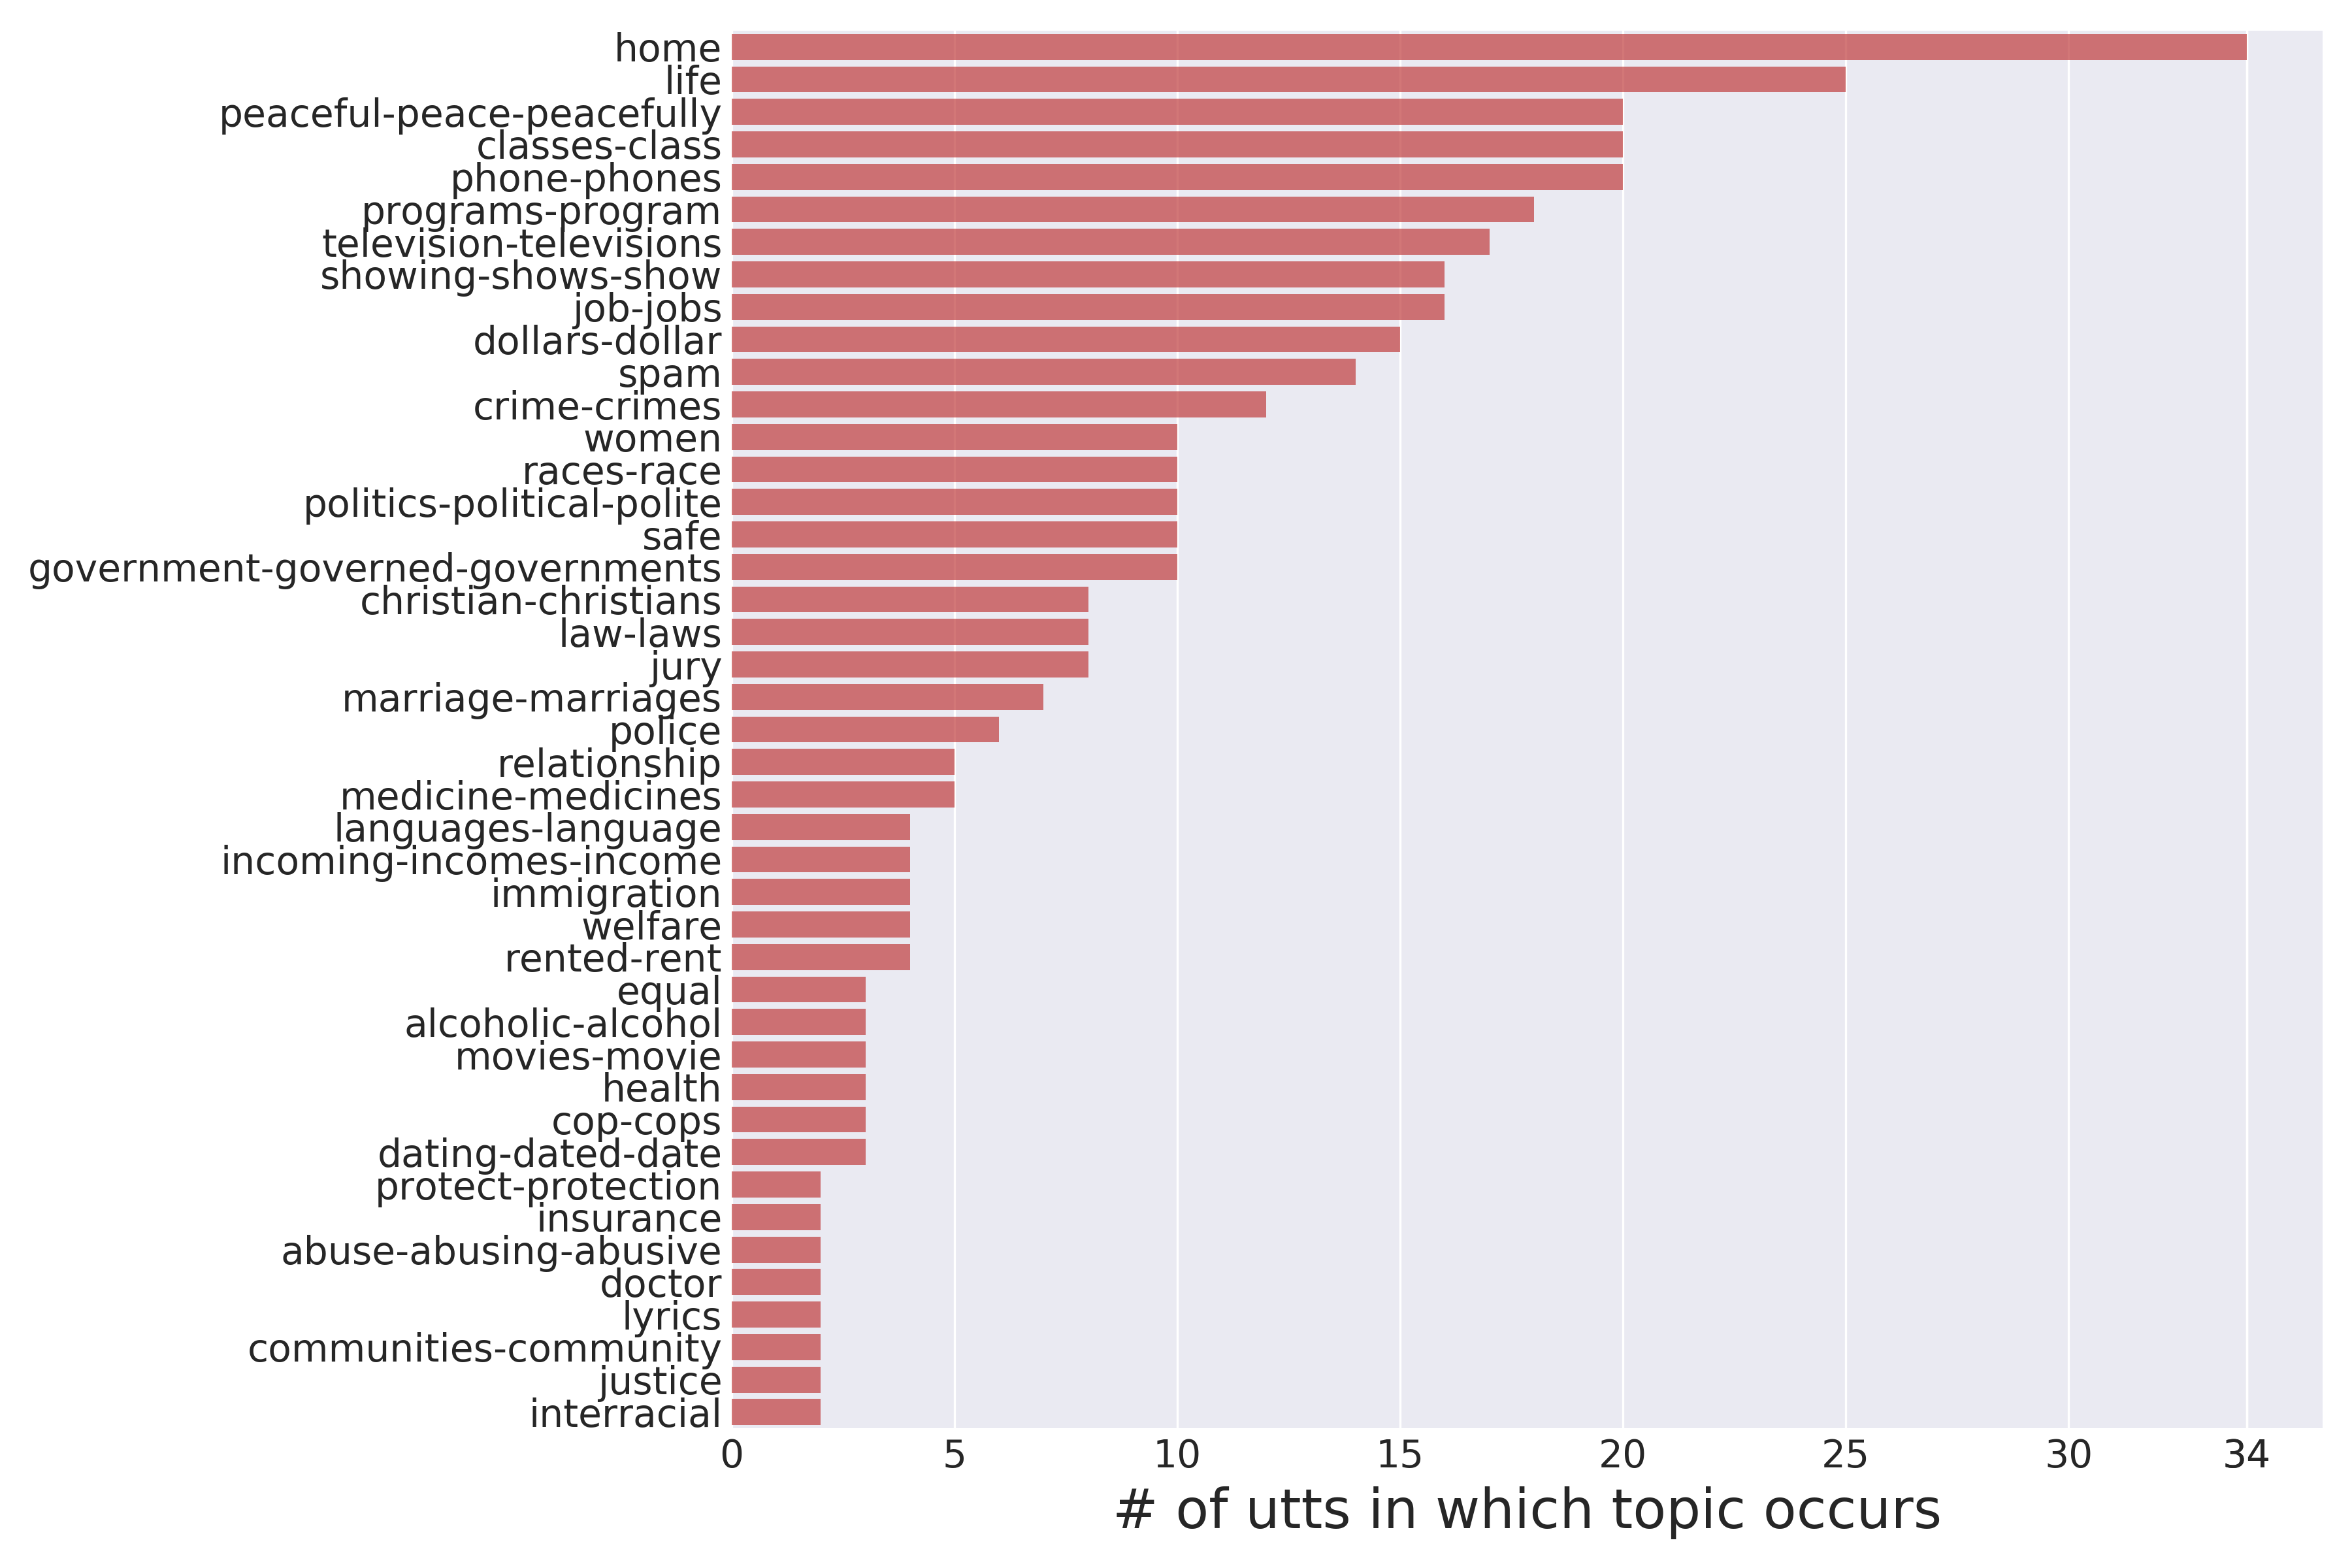

In [15]:
Image("../criseslex/sel_topics.png")

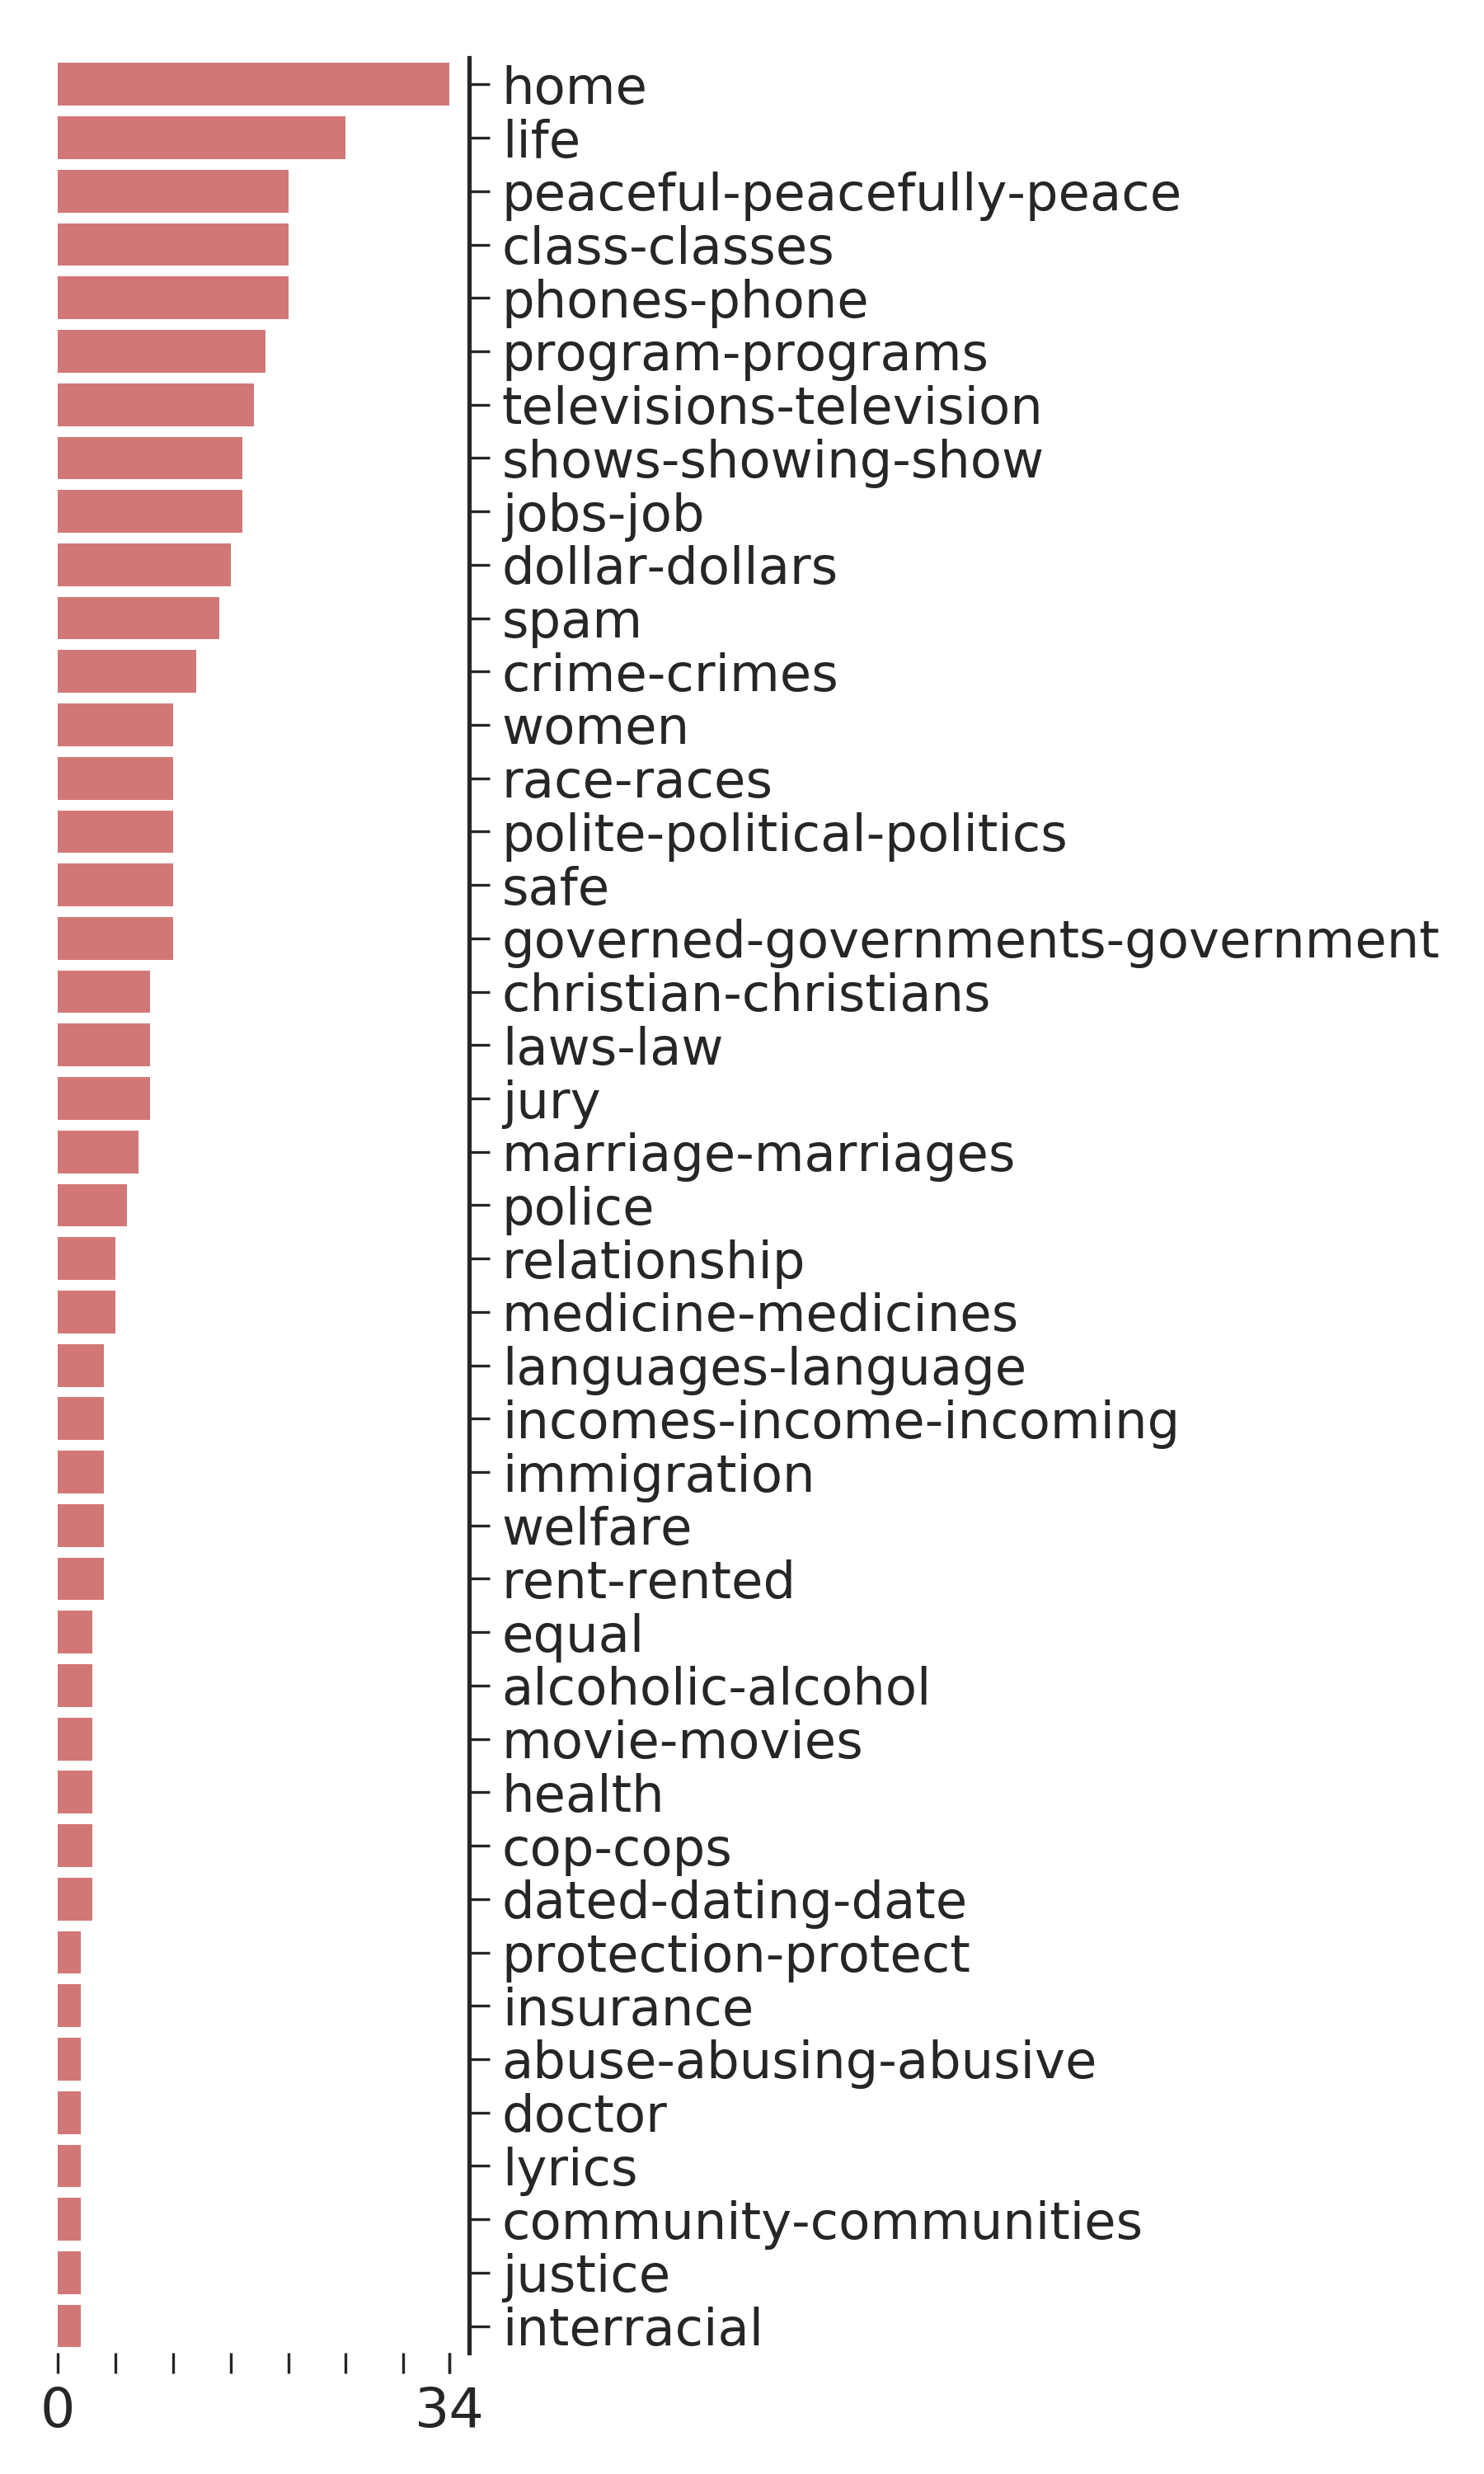

In [97]:
Image("../criseslex/sel_topics_new.png")

### Precision and Recall

In [16]:
topics_metrics = {}

topics_metrics['google'] = {'p' : 75, 'r' : 69}

In [17]:
for key, m_fil in model_files.items():
    with open(os.path.join(m_fil, "topics_p_r.json"), "r") as out_f:
        temp = json.load(out_f)
        topics_metrics[key] = {'p':temp['precision']*100, 'r':temp['recall']*100}

In [18]:
topics_metrics

{'google': {'p': 75, 'r': 69},
 's2w-0.10': {'p': 3.125, 'r': 0.5291005291005291},
 's2w-0.25': {'p': 15.789473684210526, 'r': 11.11111111111111},
 's2w-0.33': {'p': 36.868686868686865, 'r': 19.31216931216931},
 's2w-0.50': {'p': 40.76246334310851, 'r': 36.77248677248677},
 's2w-1.0': {'p': 40.35532994923858, 'r': 42.06349206349206}}

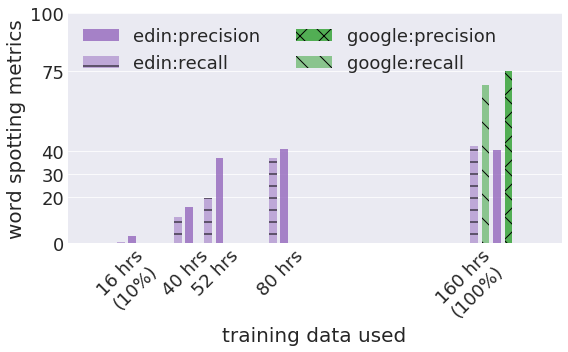

In [96]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

py_vals = [topics_metrics[k]['p'] for k in topics_metrics if k != "google"]
px_vals = x_scale-3
px_vals[-1] = 103
ax.bar(px_vals, py_vals, label="edin:precision", color=tableau20[8], hatch="", width=2, alpha=.8)

ry_vals = [topics_metrics[k]['r'] for k in topics_metrics if k != "google"]
rx_vals = x_scale-6
rx_vals[-1] = 97
ax.bar(rx_vals, ry_vals, label="edin:recall", color=tableau20[8], hatch="-", width=2, alpha=.5)


ax.bar([106], [topics_metrics['google']['p']], label="google:precision", color=tableau20[4], hatch='x', width=2, alpha=.8)
ax.bar([100], [topics_metrics['google']['r']], label="google:recall", color=tableau20[4], hatch='\\', width=2, alpha=.5)


plt.xticks(x_scale-4, x_labels, rotation=45)
plt.yticks([0,100]+list(range(20,40,10))+[40, 75], rotation=0, fontsize=20)

ax.set_xlabel('training data used', size=20)
ax.set_ylabel('word spotting metrics', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(18)

plt.yticks(fontsize=18, rotation=0)

plt.ylim(0,100)
plt.xlim(-10,120)
ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(0.9, 1.01), framealpha=0, fontsize=18, ncol=2)

fig.tight_layout()
fig.savefig(fname="word_spotting_prec_rec.png", dpi=300)

In [20]:
model_files

{'s2w-0.10': './sp2enw/sp_.10/',
 's2w-0.25': './sp2enw/sp_.25/',
 's2w-0.33': './sp2enw/sp_.33/',
 's2w-0.50': './sp2enw/sp_.50/',
 's2w-1.0': './sp2enw/sp_1.0_l2e-3'}

In [21]:
m_fil = './sp2enw/sp_.33'

In [22]:
with open(os.path.join(m_fil, "topics_p_r.json"), "r") as out_f:
    all_topic_metrics = json.load(out_f)

In [23]:
sorted_topic_metrics = sorted(all_topic_metrics['terms'].items(), reverse=True, key=lambda t:t[1]['t'])

In [24]:
terms = [i[0] for i in sorted_topic_metrics]

In [25]:
t_vals = [all_topic_metrics['terms'][i]['t'] for i in terms]
tp_vals = [all_topic_metrics['terms'][i]['tp'] for i in terms]
tc_vals = [all_topic_metrics['terms'][i]['tc'] for i in terms]

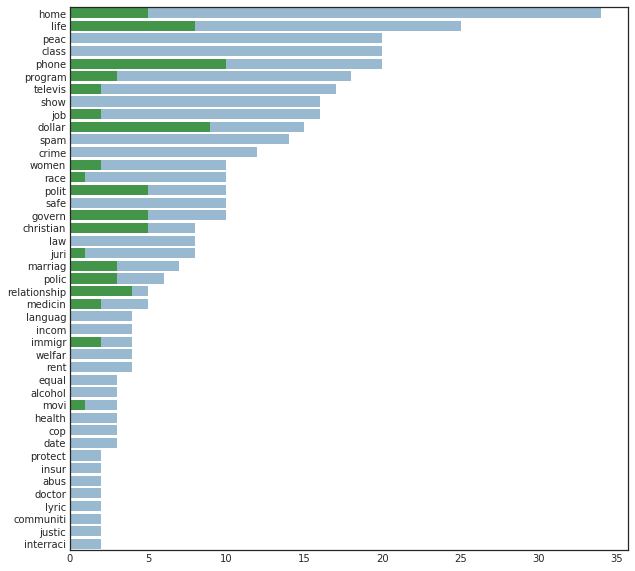

In [26]:
fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1, sharey=True)
sns.set_style("white")

sns.barplot(x=t_vals, y=terms, **{"alpha": .5, "color":tableau20[0]})
sns.barplot(x=tc_vals, y=terms, **{"alpha": .9, "color":tableau20[4]})

In [102]:
len(terms)

43